In [7]:
%pylab inline
import scipy
from scipy.sparse import coo_matrix, csr_matrix, csc_matrix, block_diag, identity, hstack
import matplotlib.pyplot as plt
from pyiga import assemble, bspline, vform, geometry, vis, solvers, utils, topology, algebra, quadrature
#from sksparse.cholmod import cholesky
from pyiga import adaptive as adap
import itertools
import time
import statistics as st
from pyiga import algebra_cy

np.set_printoptions(linewidth=100000)
np.set_printoptions(precision=5)
np.set_printoptions(formatter={'float_kind':"{:.3f}".format})

Populating the interactive namespace from numpy and matplotlib


/home/wolfman/anaconda3/lib/python3.9/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['identity', 'hstack']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


In [8]:
kvy = [8,4,8,5,2,4]
kvx = [2,4,3,6,5,8]
deg=2

b = geometry.line_segment(np.array([0,1]),np.array([2,1])).as_nurbs()
t = geometry.line_segment(np.array([1,2]),np.array([2,2])).as_nurbs()
l = geometry.NurbsFunc(bspline.KnotVector(np.array([0.,0.,0.,1.,1.,1.]),2),coeffs=np.array([[0.,1.],[0.2,1.8],[1.,2.]]),weights = np.array([1.,1/sqrt(2),1.]))
r = geometry.NurbsFunc(bspline.KnotVector(np.array([0.,0.,0.,1.,1.,1.]),2), coeffs = np.array([[2,1],[2,1.5],[2,2]]), weights = np.array([1.,1.,1.]))
kvs_g2, coeffs_g2 = geometry._combine_boundary_curves(b,t,l,r)
geo2 = geometry.NurbsFunc(kvs_g2, coeffs_g2[:,:,:2], coeffs_g2[:,:,2].reshape(3,2), premultiplied=1)

l = geometry.NurbsFunc(bspline.KnotVector(np.array([0.,0.,0.,1.,1.,1.]),2), coeffs = np.array([[2,1],[2,  1.5],[2,  2  ]]), weights = np.array([1.,1.,       1.]))
r = geometry.NurbsFunc(bspline.KnotVector(np.array([0.,0.,0.,1.,1.,1.]),2), coeffs = np.array([[3,1],[3.5,1.5],[3.5,2.5]]), weights = np.array([1.,1/sqrt(2),1.]))
b = geometry.NurbsFunc(bspline.KnotVector(np.array([0.,0.,0.,1.,1.,1.]),2), coeffs = np.array([[2,1],[2.5,1  ],[3,  1  ]]), weights = np.array([1.,1.,       1.]))
t = geometry.NurbsFunc(bspline.KnotVector(np.array([0.,0.,0.,1.,1.,1.]),2), coeffs = np.array([[2,2],[2.5,2.5],[3.5,2.5]]), weights = np.array([1.,1/sqrt(2),1.]))
kvs_g3, coeffs_g3 = geometry._combine_boundary_curves(b,t,l,r)
coeffs_g3[1,1] = np.array([2.75,1.75,1.0])
geo3 = geometry.NurbsFunc(kvs_g3, coeffs_g3[:,:,:2], coeffs_g3[:,:,2], premultiplied=1)

l = geometry.line_segment(np.array([2,1]),np.array([3,1])).as_nurbs()
r = geometry.line_segment(np.array([2.5,-.5]),np.array([3,0])).as_nurbs()
b = geometry.NurbsFunc(bspline.KnotVector(np.array([0.,0.,0.,1.,1.,1.]),2),coeffs=np.array([[2.,1],[2.5,0.5],[3,0]]),weights = np.array([1.,1.,1.]))
t = geometry.NurbsFunc(bspline.KnotVector(np.array([0.,0.,0.,1.,1.,1.]),2), coeffs = np.array([[3,1],[3,0.5],[3.5,0.5]]), weights = np.array([1.,1/sqrt(2),1.]))
kvs_g4, coeffs_g4 = geometry._combine_boundary_curves(b,t,l,r)
geo4 = geometry.NurbsFunc(kvs_g4, coeffs_g4[:,:,:2], coeffs_g4[:,:,2].reshape(2,3), premultiplied=1)

l = geometry.line_segment(np.array([2,0]),np.array([2,1])).as_nurbs()
r = geometry.line_segment(np.array([3,0]),np.array([3.5,0.5])).as_nurbs()
b = geometry.NurbsFunc(bspline.KnotVector(np.array([0.,0.,0.,1.,1.,1.]),2),coeffs=np.array([[2.,0.],[2.5,0],[2.5,-.5]]),weights = np.array([1.,1/sqrt(2),1.]))
t = geometry.NurbsFunc(bspline.KnotVector(np.array([0.,0.,0.,1.,1.,1.]),2), coeffs = np.array([[2,1],[2.5,0.5],[3,0]]), weights = np.array([1.,1.,1.]))
kvs_g5, coeffs_g5 = geometry._combine_boundary_curves(b,t,l,r)
geo5 = geometry.NurbsFunc(kvs_g5, coeffs_g5[:,:,:2], coeffs_g5[:,:,2].reshape(2,3), premultiplied=1)


kvs=[(bspline.make_knots(deg,0.0,1.0,xN),bspline.make_knots(deg,0.0,1.0,yN)) for xN,yN in zip(kvx,kvy)]
geos=[geometry.unit_square(support=((0.,1.),(0.0,0.5))).scale((2,1)),
      geometry.unit_square(support=((0.,1.),(0.5,1.))).scale((2,1)),
      # geometry.Quad(np.array([[0.,2.,1.,2.],
      #                         [1.,1.,2.,2.]])),
      geo2,
      geo3,
      # geometry.Quad(np.array([[2.,3.,2.,3.5],
      #                         [1.,1.,2.,2.5]])),
      geo4,
      # geometry.Quad(np.array([[2.,3.,3.,3.5],
      #                         [1.,0.,1.,0.5]])),
      geo5
     ]
      # geometry.Quad(np.array([[2.,2.5,2.,3.],
      #                         [0.,-0.5,1.,0.]])),]

patches = [(tuple(bspline.mapto(k[d],lambda x: g.support[d][1]*x + g.support[d][0]*(1-x)) for d in range(2)), g) for k, g in zip(kvs,geos)]

conn, interfaces = assemble.detect_interfaces(patches)
for i in range(len(interfaces)):
    (p1, bdspec1, p2, bdspec2, conn_info) = interfaces[i]
    interfaces[i] = ((p1, topology.bdspec_to_int(bdspec1), 0), (p2, topology.bdspec_to_int(bdspec2), 0), conn_info[1][0])

interfaces = interfaces + [
    ((2,0,0),(0,1,0),False),
    ((2,0,1),(1,1,0),False)
]

M = topology.PatchMesh(patches, interfaces)
MP = assemble.Multipatch(M, automatch=True)
#M.sanity_check()
#M.h_refine(patches={5:-1, 2:-1});

setting up constraints took 0.010248184204101562 seconds.
Basis setup took 0.005395650863647461 seconds


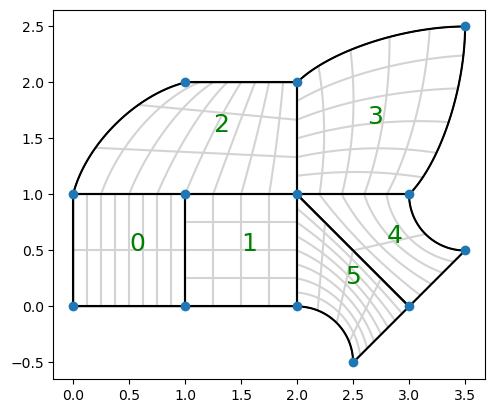

In [9]:
MP.mesh.draw(knots=1, nodes=1, patch_idx=1)

In [10]:
#MP.h_refine({2:None})
for i in range(7):
    MP.h_refine(-1)
    print(MP.numdofs)

Refinement took 0.0008301734924316406 seconds for 6 patches.
setting up constraints took 0.02981710433959961 seconds.
Basis setup took 0.014128923416137695 seconds
682
Refinement took 0.00043845176696777344 seconds for 6 patches.
setting up constraints took 0.021939992904663086 seconds.
Basis setup took 0.008791923522949219 seconds
2376
Refinement took 0.0003170967102050781 seconds for 6 patches.
setting up constraints took 0.018973588943481445 seconds.
Basis setup took 0.009361982345581055 seconds
8836
Refinement took 0.00027680397033691406 seconds for 6 patches.
setting up constraints took 0.02520155906677246 seconds.
Basis setup took 0.016739606857299805 seconds
34044
Refinement took 0.0003006458282470703 seconds for 6 patches.
setting up constraints took 0.04313087463378906 seconds.
Basis setup took 0.049558162689208984 seconds
133612
Refinement took 0.00037860870361328125 seconds for 6 patches.
setting up constraints took 0.09118103981018066 seconds.
Basis setup took 0.17723679542

In [36]:
active = np.arange(MP.Constr.shape[0], dtype=np.int32)
%timeit algebra_cy.pyx_find_ddofs(MP.Constr, active)
%timeit algebra.find_ddofs(MP.Constr, active)

3.26 ms ± 81.9 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)
32.9 ms ± 189 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [37]:
ddofs = algebra_cy.pyx_find_ddofs(MP.Constr, active)
I = scipy.sparse.identity(MP.N_ofs[-1]).tocsc()
%timeit algebra_cy.pyx_update_basis(MP.Constr, ddofs, I)
%timeit algebra.update_basis(MP.Constr, ddofs, I)

118 ms ± 1.68 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)
243 ms ± 1.42 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [38]:
Basis = algebra_cy.pyx_update_basis(MP.Constr, ddofs, scipy.sparse.identity(MP.N_ofs[-1]))
Constr = MP.Constr @ Basis
%timeit algebra_cy.pyx_compute_active_constr(Constr)
%timeit algebra.compute_active_constr(Constr)

437 µs ± 3.76 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
1.68 ms ± 15.8 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [39]:
%timeit algebra_cy.pyx_compute_basis(MP.Constr, maxiter=10)
%timeit algebra.compute_basis(MP.Constr, maxiter=10)

364 ms ± 2.98 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
573 ms ± 952 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
